In [1]:
import numpy as np
import sys
import torch
from matplotlib import pyplot as plt
import seaborn as sns
color_palette = sns.color_palette("colorblind")
sys.path.append('../')
from conjnet import Evolver
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform

plt.rcParams.update({
    "text.usetex": True,
    "font.size": '16',
})

In [2]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 


In [3]:
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [4]:
# create an evolver object and explore
evolver_1 = Evolver(mu = 0.2, om = 2.2, mu_s = 0.0, T = 2 * np.pi)

evolver_2 = Evolver(mu = 0.6, om = 0, mu_s = -0.1, T = 2 * np.pi)

num_tsteps = 100
po_in = torch.zeros((num_tsteps, 4))
po_in[:, 0] = torch.linspace(0, 2*torch.pi, num_tsteps) # 0th column is time
po_in[:, 1] = 1.0 # initial condition is at [1, 0, 0] for all inputs

po_out = evolver_1(po_in) # output is the evolved input

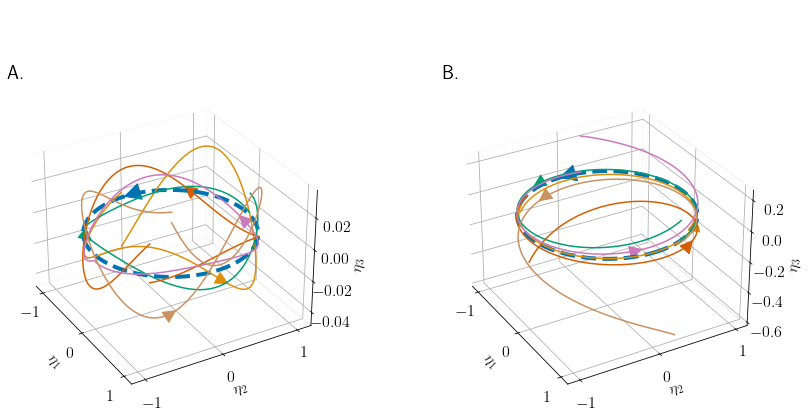

In [5]:
# plotting the output we get the unit circle
po_np = po_out.numpy() 
fig = plt.figure(figsize=(13,6))
ax_1 = fig.add_subplot(121,projection='3d')
ax_2 = fig.add_subplot(122,projection='3d')

for ax in [ax_1, ax_2]:
    ax.plot(po_np[:,0], po_np[:,1], po_np[:,2], '--', color=color_palette[0], lw=4.0)
    ax.arrow3D(
        po_np[num_tsteps//2, 0], po_np[num_tsteps//2, 1], po_np[num_tsteps//2, 2], 
        po_np[num_tsteps//2+1, 0] - po_np[num_tsteps//2, 0],
        po_np[num_tsteps//2+1, 1] -  po_np[num_tsteps//2, 1], 
        po_np[num_tsteps//2+1, 2] - po_np[num_tsteps//2, 2],
           mutation_scale=40,
           arrowstyle="-|>",
           edgecolor=color_palette[0],
           facecolor=color_palette[0]
               )

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.fill = False
    ax.set_xlabel("$\\eta_1$")
    ax.set_ylabel("$\\eta_2$")
    ax.set_zlabel("$\\eta_3$")
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    # ax.set_zticks([-0.02, 0, 0.02])
    # ax.set_zlim(-0.01,0.01)
    ax.view_init(30,-30)

evolvers = [evolver_1, evolver_2]
axes = [ax_1, ax_2]

np.random.seed(42)

for ax, evolver in zip(axes, evolvers):

    for iic in range(1,6):
        it = np.random.randint(0, num_tsteps)
        perturbic = po_np[it, :] + np.random.randn(3) * 1e-2

        perturb_in = torch.zeros((num_tsteps, 4))
        perturb_in[:, 0] = torch.linspace(0, 2*torch.pi, num_tsteps) # 0th column is time
        perturb_in[:, 1:4] = torch.tensor(perturbic)
        perturb_out = evolver(perturb_in).numpy() # output is the evolved input
        ax.plot(perturb_out[:, 0], perturb_out[:, 1], perturb_out[:, 2], color=color_palette[iic])
        ax.arrow3D(
            perturb_out[num_tsteps//2, 0], perturb_out[num_tsteps//2, 1], perturb_out[num_tsteps//2, 2], 
            perturb_out[num_tsteps//2+1, 0] - perturb_out[num_tsteps//2, 0],
            perturb_out[num_tsteps//2+1, 1] -  perturb_out[num_tsteps//2, 1], 
            perturb_out[num_tsteps//2+1, 2] - perturb_out[num_tsteps//2, 2],
            mutation_scale=30,
            arrowstyle="-|>",
            edgecolor=color_palette[iic],
            facecolor=color_palette[iic]
                )


fig.tight_layout()

ax_1.set_title("\n\n\nA.", loc='left')
ax_2.set_title("\n\n\nB.", loc='left')
fig.tight_layout()
fig.savefig("../tex/fig/linear.png", dpi=200)


In [6]:
!/mpcdf/soft/SLE_15/packages/x86_64/imagemagick/7.1.1/bin/convert -trim linear.png ../tex/fig/linear.png

convert: unable to open image 'linear.png': No such file or directory @ error/blob.c/OpenBlob/3569.
convert: no images defined `../tex/fig/linear.png' @ error/convert.c/ConvertImageCommand/3342.
